In [224]:
import random
import math
import matplotlib.pyplot as plt
import networkx as nx
import experiments_func as ef
import block_division_func as bd

KeyboardInterrupt: 

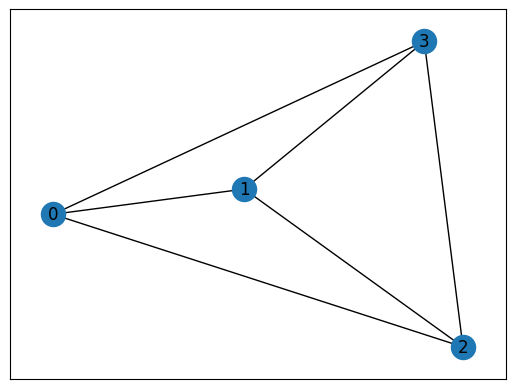

In [227]:
import random
import networkx as nx
from deap import base, creator, tools

# Define the problem constants
num_tasks = 6
num_computers = 4
total_capacity = 20
initial_state = [1, 0, 2, 2, 3, 2, 0, 0, 1, 1, 3, 3]
connection_relations = [[1, 2, 3], [0, 2, 3], [0, 1, 3, 4, 5], [0, 1, 2, 4, 5], [5], [4]]

# Create a directed graph for communication costs
G = nx.Graph()
G.add_nodes_from(range(num_computers-1))
for i in range(num_computers):
    for j in range(num_computers):
        j = random.randint(0, num_computers-1)
        while i == j:
            j = random.randint(0, num_computers-1)
        G.add_edge(i, j, weight=random.randint(1, 10))  # Assign random communication costs
nx.draw_networkx(G, with_labels=True)

# Create the DEAP toolbox
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

# Define the initialization function
def init_individual():
    individual = set(initial_state)
    while len(individual) < num_tasks:
        individual.add(random.choice(initial_state))
    return creator.Individual(list(individual))

toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define the evaluation function
def evaluate(individual):
    total_cost = 0
    converter = individual.copy()
    for i in range(num_tasks):
        computer_i = converter[i]
        for j in connection_relations[i]:
            computer_j = converter[j]
            print(computer_i, computer_j)
            cost = nx.dijkstra_path_length(G, computer_i, computer_j)
            total_cost += cost
    return total_cost,

toolbox.register("evaluate", evaluate)

# Define the genetic operators
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Set up the algorithm parameters
population_size = 10
num_generations = 10

# Create the initial population
population = toolbox.population(n=population_size)

# Run the genetic algorithm
for gen in range(num_generations):
    offspring = toolbox.select(population, k=len(population))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.8:  # Apply crossover with 80% probability
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:  # Apply mutation with 20% probability
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_individuals = [ind for ind in offspring if not ind.fitness.valid]
    fitness_values = toolbox.map(toolbox.evaluate, invalid_individuals)
    for ind, fit in zip(invalid_individuals, fitness_values):
        ind.fitness.values = fit

    population[:] = offspring

# Get the best individual from the population
best_individual = tools.selBest(population, k=1)[0]

# Print the best individual and its fitness
print("Best Individual:", best_individual)
print("Best Fitness:", best_individual.fitness.values[0])
